# Uniaxial compression of a faulted unbounded domain
![Fault](./images/setup.png)

## Problem description
A single fault in an unbounded domain is subject to a compressive remote stress $\sigma$. The crack has length $L_f$ and inclination angle $\alpha$. Friction angle of the fault is $\phi$, and the elastic parameters of the surrounding material are $E$ and $\nu$. 

The analytical solutions for the normal traction $t_n$ and slip $\Delta u_s$ on the crack surface are given by <br>
&emsp; &emsp; $t_n = - \sigma \sin^2{\alpha}$ <br>
&emsp; &emsp; $\Delta u_s = \frac{4(1 - \nu^2)}{E} \sigma \sin{\alpha}(\cos{\alpha} - \sin{\alpha} \tan{\phi}) \sqrt{\frac{L_f^2}{4} - \left(\eta - \frac{L_f}{2}\right)^2}$<br>
where $\eta$ is the distance along the fault measured from the its center, $\sigma < 0$, $0\leq \eta \leq L_f$.


## Setting up material parameters and model geometry

In [1]:
import matplotlib.pyplot as plt
# import triangluation routine to plot meshes
import matplotlib.tri as tri
# setting a default image size large enough
plt.rcParams['figure.figsize'] = [10, 10]
import gmsh
import akantu as aka
import numpy as np
import math
import os
import sys
sys.path.append(os.path.join(sys.path[0], '..', 'analytical_solutions'))
import analytical_solutions as an_sol

In [2]:
# geometric parameters
w = h = 1     # width (x-axis)
el_size = w / 20
fault_length = w / 8
fault_el_size = fault_length / 45
coh_type = aka._cohesive_2d_4

# material parameters
E = 1e9  # Young modulus (Pa)
poisson = 0.25
friction_angle = np.pi / 6
alpha = np.pi / 4 # fault inclination angle
load = 5e6  # pressure sides (Pa)
penalty = E * 1e3 # determines normal force on the fault
penalty_for_friction = E * 1e1  # relates tangential slip to friction force

## Define custom material
A cohesive material inherits from MaterialCohesiveLinearFriction. Its differs from the parent by having maximum value of damage (=1). By this modification, cohesive elements do not have any resting fracture energy and represent a fully developed crack or fault. Its friction functionality is not affected by this modification.

In [3]:
# class MaterialFrictionalFault(aka.MaterialCohesiveLinear2D):
class MaterialFrictionalFault(aka.MaterialCohesiveLinearFriction2D):
    def __init__(self, model, _id):
        super().__init__(model, _id)
        self.registerInternalReal("sliding", 1)
        self.registerInternalReal('quad_coordinates', 2)

    def initMaterial(self):
        super().initMaterial()
        delta_c = self.getReal("delta_c")
        sigma_c = self.getReal("sigma_c")
        G_c = self.getReal("G_c")

        if (delta_c != 0.):
            self.setDefaultValueToInternalReal("delta_max", delta_c)
        else:
            self.setDefaultValueToInternalReal("delta_max", 2 * G_c / sigma_c)

    def computeTraction(self, normals, el_type, ghost_type):
        super().computeTraction(normals, el_type, ghost_type)
        openings = self.getOpening(el_type, ghost_type).copy()
        slidings = self.getInternalReal("sliding")(el_type, ghost_type)
        for el in range(normals.shape[0]):
            normal = normals[el].ravel()
            opening = openings[el].ravel()
            normal_opening = opening.dot(normal) * normal

            tangential_opening = opening
            tangential_opening -= normal_opening
            slidings[el] = np.linalg.norm(tangential_opening)

# register material to the MaterialFactory
def allocator(_dim, unused, model, _id):
    return MaterialFrictionalFault(model, _id)


mat_factory = aka.MaterialFactory.getInstance()
mat_factory.registerAllocator("material_frictional_fault", allocator)

In [4]:
material_file = f"""
material elastic [
    name = rock
    E   = {E}   # young's modulus [GPa]
    nu  = {poisson}      # poisson's ratio
]

material material_frictional_fault [
    name = fault
    beta = 1                       # weighting parameter for sliding and normal opening (default: 0)
    G_c = 1                        # Mode I fracture energy (we model fully developed crack so do not care)
    penalty = {penalty}            # stiffness in compression to prevent penetration
    sigma_c = 1.0                  # critical stress sigma_c  (default: 0) (we do not care)
    contact_after_breaking = true  # Activation of contact when the elements are fully damaged
    mu = {np.tan(friction_angle)}  # Maximum value of the friction coefficient
    penalty_for_friction = {penalty_for_friction}   # Penalty parameter for the friction behavior
]
"""

# writing the material file
open('material.dat', 'w').write(material_file)

# reading the material file
material_file = 'material.dat'
aka.parseInput(material_file)

## Generating the mesh

In [5]:
gmsh.initialize()

gmsh.model.add("faulted_rectangle")
# define domain corners
gmsh.model.geo.addPoint(0, 0, 0, el_size, 1)
gmsh.model.geo.addPoint(w, 0, 0, el_size, 2)
gmsh.model.geo.addPoint(w, h, 0, el_size, 3)
gmsh.model.geo.addPoint(0, h, 0, el_size, 4)

gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
gmsh.model.geo.addPlaneSurface([1], 1)
nb_el_per_side = int(w / el_size)
gmsh.model.geo.mesh.setTransfiniteCurve(1, nb_el_per_side + 1)
gmsh.model.geo.mesh.setTransfiniteCurve(3, nb_el_per_side + 1)
gmsh.model.geo.mesh.setTransfiniteCurve(2, nb_el_per_side + 1)
gmsh.model.geo.mesh.setTransfiniteCurve(4, nb_el_per_side + 1)

# define fault corners
fault_proj = fault_length * np.array([np.cos(alpha), np.sin(alpha)])
gmsh.model.geo.addPoint(
    (w - fault_proj[0])/2, (h + fault_proj[1])/2, 0, fault_el_size, 5)
gmsh.model.geo.addPoint(
    (w + fault_proj[0])/2, (h - fault_proj[1])/2, 0, fault_el_size, 6)
gmsh.model.geo.addLine(5, 6, 5)
gmsh.model.geo.synchronize()
gmsh.model.mesh.embed(1, [5], 2, 1)

gmsh.model.addPhysicalGroup(1, [1], name="bottom")
gmsh.model.addPhysicalGroup(1, [2], name="right")
gmsh.model.addPhysicalGroup(1, [3], name="top")
gmsh.model.addPhysicalGroup(1, [4], name="left")
gmsh.model.addPhysicalGroup(1, [5], name="fault")
gmsh.model.addPhysicalGroup(2, [1], name="rectangle")

gmsh.model.mesh.generate(2)
gmsh.write("faulted_rectangle.msh")
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.000173791s, CPU 0.000274s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0431926s, CPU 0.042428s)
Info    : 1878 nodes 3805 elements
Info    : Writing 'faulted_rectangle.msh'...
Info    : Done writing 'faulted_rectangle.msh'


## Initialize SolidMechanicsCohesiveModel

In [6]:
dim = 2
mesh_file = 'faulted_rectangle.msh'
mesh = aka.Mesh(dim)
mesh.read(mesh_file)
model = aka.SolidMechanicsModelCohesive(mesh)
model.getElementInserter().addPhysicalSurface("fault")
model.initFull(_analysis_method=aka._static, _is_extrinsic=False)

## Set up boundary condtitions

In [7]:
# set the displacement/Dirichlet boundary conditions
model.applyBC(aka.FixedValue(0.0, aka._y), "bottom")

# fix the Y-disp of a central node of the bottom
nodes = mesh.getNodes()
blockedDOFs = model.getBlockedDOFs()
for id, node in enumerate(nodes):
    if math.isclose(node[0], w * 0.5) and (node[1] == 0):
        blockedDOFs[id, 0] = True
        break

# set the force/Neumann boundary conditions
traction = np.array([load, 0])
model.applyBC(aka.FromTraction(traction), "left")
model.applyBC(aka.FromTraction(-traction), "right")

## Initialize dumpers

In [8]:
model.setBaseName("solid")
model.addDumpFieldVector("displacement")
model.addDumpFieldVector("external_force")
model.addDumpField("strain")
model.addDumpField("stress")
model.addDumpField("blocked_dofs")

model.setBaseNameToDumper("cohesive elements", "cohesive")
model.addDumpFieldVectorToDumper("cohesive elements", "displacement")
model.addDumpFieldToDumper("cohesive elements", "damage")
model.addDumpFieldVectorToDumper("cohesive elements", "tractions")
model.addDumpFieldVectorToDumper("cohesive elements", "opening")
model.addDumpFieldToDumper("cohesive elements", "sliding")

model.dump()
model.dump("cohesive elements")

In [9]:
# set up solver parameters
solver = model.getNonLinearSolver()
solver.set("max_iterations", 30)
solver.set("threshold", 1e-6)
solver.set("convergence_type", aka.SolveConvergenceCriteria.solution)

In [10]:
try:
    model.solveStep()
except Exception:
    error = solver.getError()
    nb_iter = solver.getNbIterations()
    print(f"Cohesive model didn't converge in {nb_iter} with error = {error}")
    model.dump()
    model.dump("cohesive elements")
    raise
nb_iter = solver.getNbIterations()
print(f"Cohesive model converged in {nb_iter} iterations")
model.dump()
model.dump("cohesive elements")

Cohesive model converged in 9 iterations


Here, we will plot resulting norm of displacement across the domain.

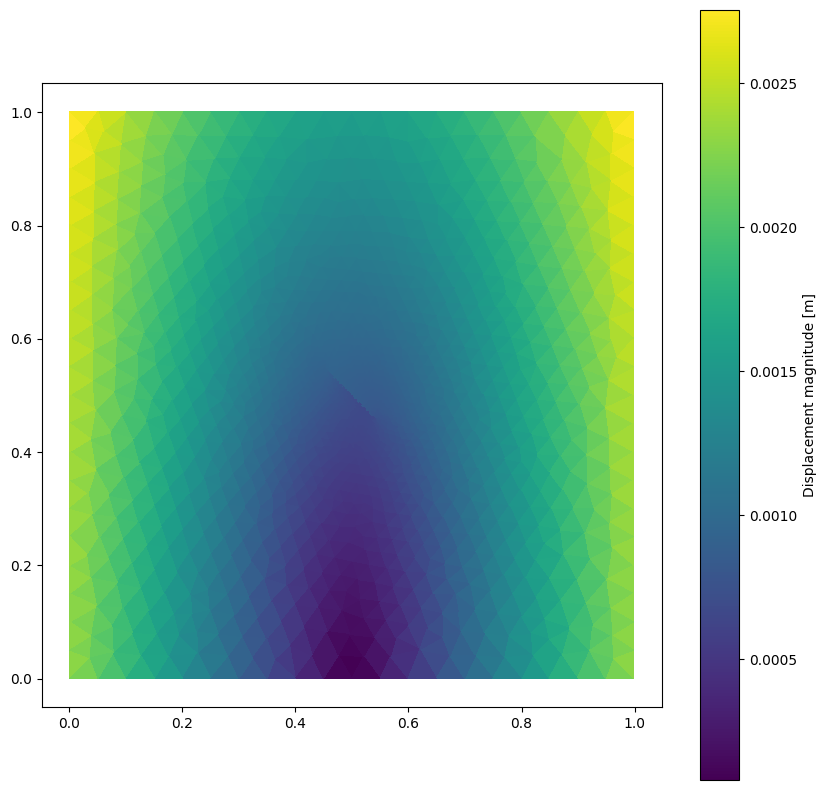

In [11]:
plt.axes().set_aspect('equal')
mesh = model.getMesh()
conn = mesh.getConnectivity(aka._triangle_3)
nodes = mesh.getNodes()
u = model.getDisplacement()
magnified_triangles = tri.Triangulation(nodes[:, 0]+u[:,0], nodes[:, 1]+u[:,1], conn)
stress_field = model.getMaterial(0).getStress(aka._triangle_3)
stress_disp = plt.tripcolor(magnified_triangles, np.linalg.norm(u, axis=1))
cbar = plt.colorbar(stress_disp)
cbar.set_label('Displacement magnitude [m]')

### Plot the sliding vs position along the crack and compare with the analytical solution

In [12]:
cohesive_mat = model.getMaterial("fault")
fe_engine = model.getFEEngine("CohesiveFEEngine")
element_filter = cohesive_mat.getElementFilter()
coh_filter = element_filter(coh_type, aka._not_ghost)
nb_elem = coh_filter.size
quad_coords = cohesive_mat.getInternalReal("quad_coordinates")
fe_engine.computeIntegrationPointsCoordinates(
    quad_coords, element_filter)
coh_quad_coords = quad_coords(coh_type)
slidings = cohesive_mat.getInternalReal("sliding")(coh_type)

# prepare distances along the crack
left_corner_coord = [w / 2 - fault_length *
                     np.cos(alpha) / 2, h / 2 + fault_length * np.sin(alpha) / 2]
distance_vector = coh_quad_coords.copy()
distance_vector -= left_corner_coord
distance_from_corner = np.linalg.norm(distance_vector, axis=1)
distance_sorted = np.sort(distance_from_corner)

# extract normal and shear tractions at the quad points
tractions = cohesive_mat.getTraction(coh_type)
contact_tractions = cohesive_mat.getInternalReal("contact_tractions")(coh_type)
normals = cohesive_mat.getNormalsAtQuads(coh_type)
tractions_n = np.zeros(normals.shape[0])
tractions_s = np.zeros(normals.shape[0])
for el in range(normals.shape[0]):
    normal = normals[el].ravel()
    traction = tractions[el].ravel()
    contact_traction = contact_tractions[el].ravel()
    t_n = traction.dot(normal) * normal
    t_s = traction - t_n
    tractions_n[el] = np.sqrt(contact_traction.dot(contact_traction))
    tractions_s[el] = np.linalg.norm(t_s)


shear_sliding_analytic,t_n_analytic,t_s_analytic = an_sol.inclined_fault_solution(distance_sorted, fault_length/2, alpha, load, E, poisson, friction_angle)

Below we plot normal traction along the fault and compare it to the projection of the horizontal load on the normal to the fault.

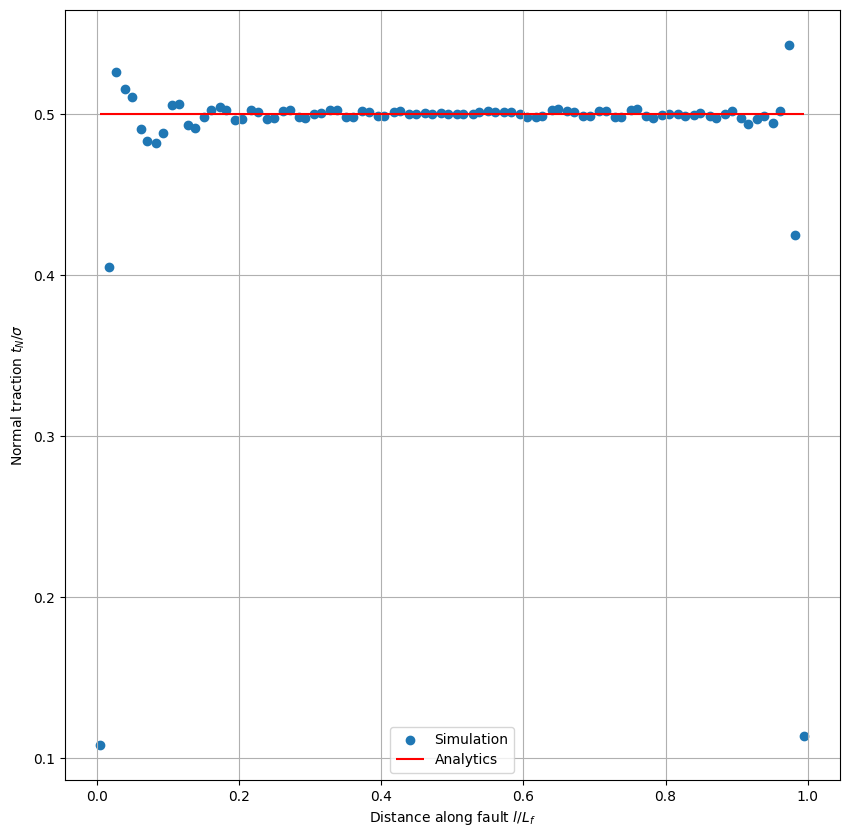

In [13]:
# plot
plt.figure()
plt.scatter(distance_from_corner/fault_length, tractions_n/load, label="Simulation")
plt.hlines(t_n_analytic/load, distance_sorted[0]/fault_length, distance_sorted[-1]/fault_length, 'r', label="Analytics")
plt.xlabel(r'Distance along fault $l / L_f$')
plt.ylabel(r'Normal traction $t_N/\sigma$')
plt.legend(loc='lower center')
# plt.savefig('terzaghi.png', dpi = 300)
plt.grid()
plt.show()

Below we plot the shear traction and compare it to the projection of the horizontal load on the fault axis.

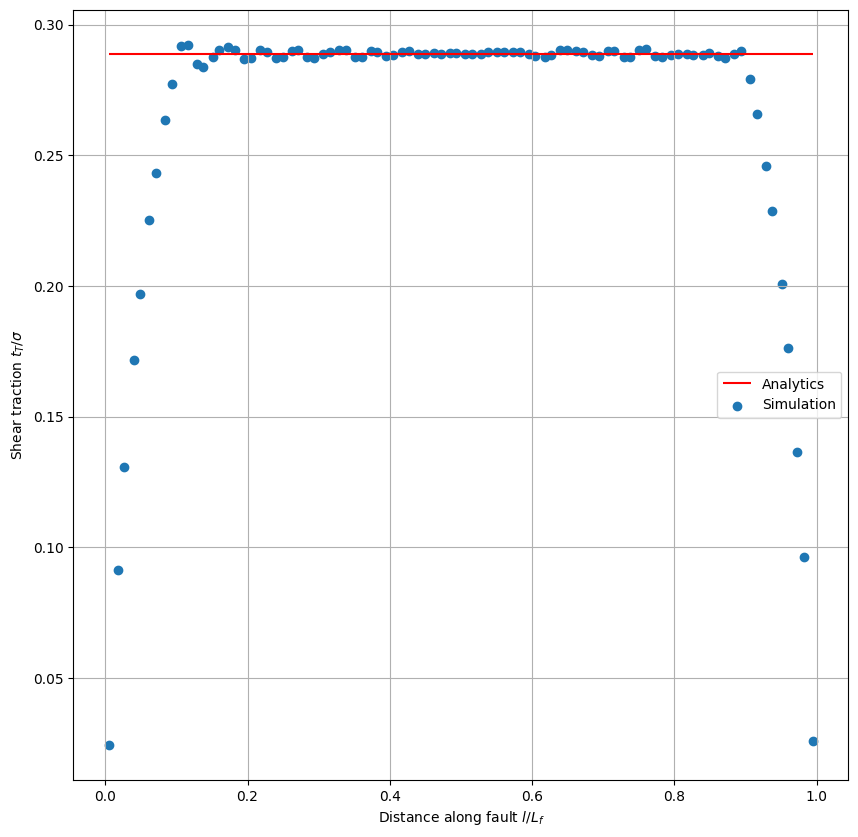

In [14]:
# plot
plt.figure()
plt.hlines(t_s_analytic/load, distance_sorted[0]/fault_length,
           distance_sorted[-1]/fault_length, 'r', label="Analytics")
plt.scatter(distance_from_corner/fault_length, tractions_s/load, label="Simulation")
plt.xlabel(r'Distance along fault $l / L_f$')
plt.ylabel('Force [Pa]')
plt.ylabel(r'Shear traction $t_T/\sigma$')
plt.legend(loc='best')
# plt.savefig('terzaghi.png', dpi = 300)
plt.grid()
plt.show()

Finally, we compare the sliding along the fault with the analytical solution.

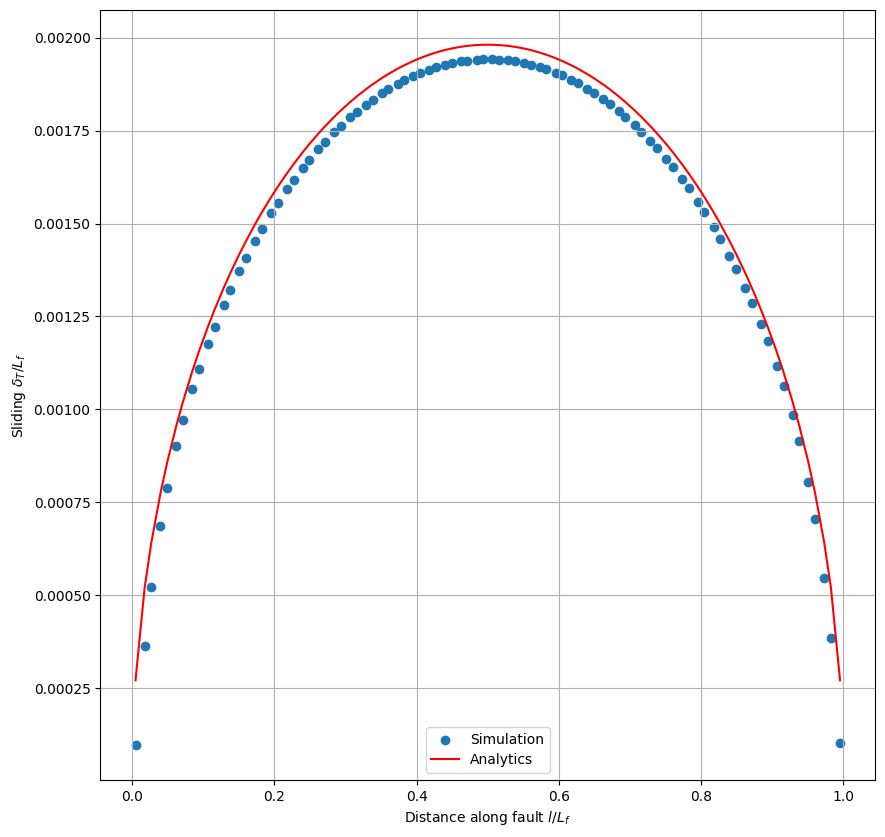

In [15]:
# plot
plt.figure()
plt.scatter(distance_from_corner/fault_length, slidings/fault_length, label="Simulation")
plt.plot(distance_sorted/fault_length, shear_sliding_analytic/fault_length, 'r', label="Analytics")
plt.xlabel(r'Distance along fault $l / L_f$')
plt.ylabel(r'Sliding $\delta_T / L_f$')
plt.legend(loc='lower center')
plt.grid()
plt.show()

### Concluding notes
1. The variable $\tau_t^c = \sigma \sin{\alpha}(\cos{\alpha} - \sin{\alpha} \tan{\phi})$ called in the original paper of Phan et al as the shear traction is actually not. The actual shear traction upon reaching the friction value becomes equal to the friction value $\tau_{max} = - \sigma \sin{\alpha} \tan{\phi}$ in a spirit of perfect plasticity. Therefore, the solution for displacement includes a different variable which is a difference between the actuall driving force in tangential direction and the friction.
2. The solution depends strongly on the penalty parameter for friction. Having this value low allows sliding without generating frictional forces and therefore never reaching the maximum friction. Idealy this value is infinit which is not achievable due to the numerical stiffening of the problem. Therefore a sufficiently high value has to be chosen. In my case, the value 10 times larger than E worked out. Further increase of penalty led to convergence issues.
3. Refinement of the crack mesh improves the resolution of the sliding and matching the analytical solution. I believe that the main problem is in the corner elements of the fault. Those ones did not reach the sliding mode ($t_s < \tau_{max}$) (see figure before last) and therefore they don't produce sliding expected by the analytic solution (the whole crack is sliding). Ideally, one should increase the penalty for friction (see the entry before), but as it leads to no convergence, I have refined the mesh. This allowed to improve solution significantly. For the perfect match, I believe the convergence could be improved and penalty for friction should be increased more.   